In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, LSTM
from sklearn.preprocessing import MinMaxScaler
import os

# Parameters
n_days_to_predict = 15  # Number of days to predict ahead
training_period = 10  # Number of days to use as input for LSTM
path = "AAPL.csv"  # Path to your stock data file

# Load and preprocess the dataset
headers = ["Date", "Open", "High", "Low", "Close", "Adj Close", "Volume"]
df = pd.read_csv(path, names=headers, skiprows=1)  # Skip the header
df.replace("null", np.nan, inplace=True)
df[["Open", "High", "Low", "Close", "Adj Close", "Volume"]] = df[["Open", "High", "Low", "Close", "Adj Close", "Volume"]].astype(float)
df.set_index("Date", inplace=True)

# Filter the 'Close' column (target variable)
data = df.filter(['Close'])
dataset = data.values

# Normalize the dataset using MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

# Create the training data using historical data
x_train, y_train = [], []

# Use the last `training_period` days to predict the next day
for i in range(training_period, len(scaled_data)):
    x_train.append(scaled_data[i - training_period:i, 0])
    y_train.append(scaled_data[i, 0])

# Convert the lists into numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)

# Reshape the input to be [samples, time steps, features]
x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))

# Step 1: Build and train the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], 1)))  # LSTM layer
model.add(LSTM(units=50, return_sequences=False))  # Second LSTM layer
model.add(Dense(units=25))  # Dense layer to reduce complexity
model.add(Dense(units=1))  # Output layer

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(x_train, y_train, batch_size=1, epochs=5)


2024-11-18 14:38:15.760315: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-18 14:38:15.777911: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-18 14:38:15.791363: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-18 14:38:15.795467: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-18 14:38:15.809164: I tensorflow/core/platform/cpu_feature_guar

Epoch 1/5


/home/mili/.local/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2584/2584 ━━━━━━━━━━━━━━━━━━━━ 36s 13ms/step - loss: 0.0035
Epoch 2/5
2584/2584 ━━━━━━━━━━━━━━━━━━━━ 29s 11ms/step - loss: 5.9245e-04
Epoch 3/5
2584/2584 ━━━━━━━━━━━━━━━━━━━━ 34s 13ms/step - loss: 4.6443e-04
Epoch 4/5
2584/2584 ━━━━━━━━━━━━━━━━━━━━ 30s 12ms/step - loss: 3.4832e-04
Epoch 5/5
2584/2584 ━━━━━━━━━━━━━━━━━━━━ 39s 15ms/step - loss: 2.6932e-04
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


ValueError: all the input arrays must have same number of dimensions, but the array at index 0 has 3 dimension(s) and the array at index 1 has 4 dimension(s)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
(1, 1, 1)
(1, 9, 1)
(1, 10, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
(1, 1, 1)
(1, 9, 1)
(1, 10, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
(1, 1, 1)
(1, 9, 1)
(1, 10, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
(1, 1, 1)
(1, 9, 1)
(1, 10, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
(1, 1, 1)
(1, 9, 1)
(1, 10, 1)


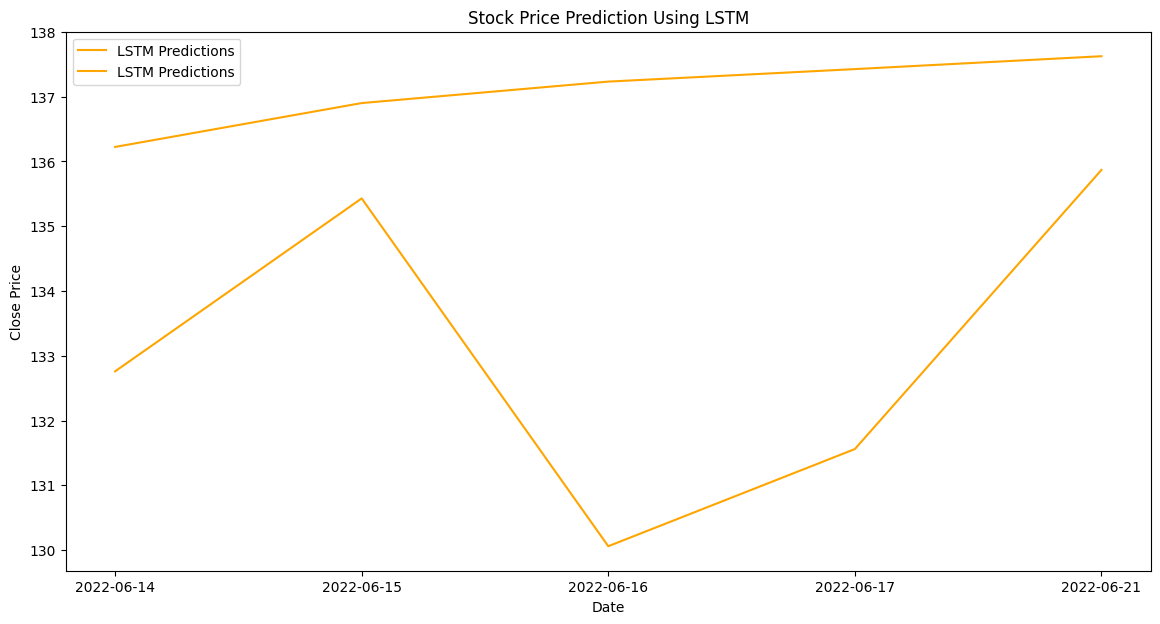

In [19]:

# Step 2: Make predictions on the training data and the test data
# Predict the next `n_days_to_predict` future stock prices using LSTM

# Create the test data for predictions (use the last `training_period` days for prediction)
x_test = scaled_data[-training_period:].reshape(1, -1, 1)

predictions = []

for i in range(n_days_to_predict):
    # Predict the next value using LSTM
    lstm_pred = model.predict(x_test)
    lstm_pred_rescaled = scaler.inverse_transform(lstm_pred)

    # Append the prediction to the list
    predictions.append(lstm_pred_rescaled[0, 0])

    # Update the test data (shift it by adding the latest prediction)
    print(lstm_pred.reshape(1,1,1).shape)
    print(x_test[:, 1:, :].shape)
    print(np.append(x_test[:, 1:, :], lstm_pred.reshape(1,1,1), axis=1).shape)
    # x_test = np.append(x_test[:, 1:, :], [[lstm_pred]], axis=1)
    x_test = np.append(x_test[:, 1:, :], lstm_pred.reshape(1,1,1), axis=1)

# Step 3: Visualize the predictions
plt.figure(figsize=(14, 7))
# Step 2: Create test data (last 10 days)
test_data = scaled_data[-(training_period + n_days_to_predict):]  # Get the last n_days_to_predict plus the training period
x_test = test_data[:-n_days_to_predict]  # Input data for prediction
y_test = test_data[-n_days_to_predict:]  # Actual values for comparison

y_test_rescaled = scaler.inverse_transform(y_test)
plt.plot(data.index[-len(predictions):], y_test_rescaled, label='LSTM Predictions', color='orange')
plt.plot(data.index[-len(predictions):], predictions, label='LSTM Predictions', color='orange')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Stock Price Prediction Using LSTM')
plt.legend()
plt.show()
